In [9]:
import numpy as np
import torch
from torch.utils.data import Dataset
import os
import augmentation
import matplotlib.pyplot as plt

In [40]:
class PairedPatchDataset(torch.utils.data.Dataset):

    def __init__(self, hr_directory, translation, rotation, flip, downsample):
        self.hr_directory = hr_directory
        # join folder paths with each hr patch within the folder
        self.hr_paths = [os.path.join(hr_directory, f) for f in os.listdir(hr_directory)]
        
        # augmentation args
        self.translation = translation
        self.rotation = rotation
        self.flip = flip
        self.downsample = downsample


    def __len__(self):
        return len(self.hr_paths)
        

    def augment(self, hr_patch, flip_prob):
        if self.translation:
            image = augmentation.translation(hr_patch)
        if self.rotation:
            image = augmentation.rotation(hr_patch)
        if self.flip:
            image = augmentation.flip(hr_patch, flip_prob)
        
        downsampled_img = augmentation.downsample(hr_patch)
        return image, downsampled_img



    def __getitem__(self, index):
        # load hr image
        hr_patch = np.load(self.hr_paths[index])

        # apply augmentation to HR and generate corresponding LR 
        hr_aug, lr_aug = self.augment(hr_patch, flip_prob = 0.5)
        return torch.tensor(hr_aug, dtype = torch.float32), torch.tensor(lr_aug, dtype = torch.float32)



## Test

In [24]:
import tempfile

In [25]:
temp_dir = tempfile.mkdtemp()  # temporary directory

# want 5 random 3D patches
num_files = 5
for i in range(num_files):
    random_patch = np.random.rand(32, 32, 32)
    file_path = os.path.join(temp_dir, f"patch_{i}.npy")
    np.save(file_path, random_patch)

print(f"Temporary directory created at: {temp_dir}")
print("Random .npy files saved.")


Temporary directory created at: /var/folders/34/x55w1k8j3gv4kpw6022k7zbr0000gn/T/tmp80jg51w8
Random .npy files saved.


In [68]:
directory = temp_dir
test_dataset = PairedPatchDataset(hr_directory = directory, 
                                    translation = True, 
                                    rotation = True, 
                                    flip = True, 
                                    downsample = True)

In [69]:
print("Dataset length:", len(test_dataset))


Dataset length: 6


In [75]:
sample_hr, sample_lr = test_dataset[1]  # sometimes lead to error: 
# Certain augmentations (like flipping an array with [::-1] in NumPy) effectively create a view of the original array with reversed memory order.
print("Sample HR shape:", sample_hr.shape)
print("Sample LR shape:", sample_lr.shape)

chosen_axis:  (0, 2)
scale:  5
Sample HR shape: torch.Size([32, 32, 32])
Sample LR shape: torch.Size([30, 30, 30])


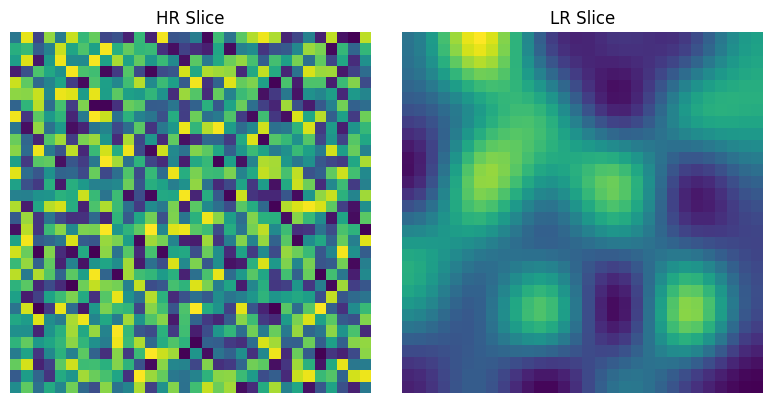

In [77]:
# Convert PyTorch tensors to NumPy arrays
hr_np = sample_hr.numpy()
lr_np = sample_lr.numpy()

# Determine how to slice the 3D volume ([D, H, W])
# Pick the middle slice along the depth dimension
d_hr = hr_np.shape[0] // 2
d_lr = lr_np.shape[0] // 2

# Extract that 2D slice
hr_slice = hr_np[d_hr, :, :]
lr_slice = lr_np[d_lr, :, :]

# Plot the two slices side by side
fig, axes = plt.subplots(1, 2, figsize=(8, 4))

axes[0].imshow(hr_slice)
axes[0].set_title('HR Slice')
axes[0].axis('off')

axes[1].imshow(lr_slice)
axes[1].set_title('LR Slice')
axes[1].axis('off')

plt.tight_layout()
plt.show()
